# ML-Demo


In [37]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import folium
from geopy.geocoders import Nominatim
import time
%matplotlib inline

**_Context_**
Imaging you were heading up a team with a project to solve: Given this data, solve how we can best predict the fares on future rides in the bay area and San Francisco.<br>

Suppose you had a large database of information. We can assume that our csv file is a random sample of that data so we can work with it locally.

This notebook is a sample of how one might go about creating a baseline solution to inform their project. 

You might not be an expert in the taxi industry, but with some analysis with machine learning, you have the power to make an impact. 

This is what I would do in the first two hours of to familiarize myself with the problem and how to move forward with a complicated project.

This notebook was made in conjunction with the accompanying slides

---
# Part 1: Inital Exploration and Preprocessing 

The first part of the notebook is to get us familiar with our dataset. Before starting a project, its good to have a high level view of whats going on, so we can better inform our more nuanced decisions.

**We will:** 
1. Read in our data 
1. Preproccess some columns 
1. Explore and visualize our data
1. Check for outliers


## Reading in the Data

In [38]:
sf_taxi_trips = pd.read_csv('Taxi_Train.csv').drop(['id'],axis=1) # dropping irrelevant id column thats a repeat of the index

In [39]:
sf_taxi_trips.memory_usage(deep=True).sum() * 1e-6

8.452463

In [40]:
print(sf_taxi_trips.shape)
sf_taxi_trips.head()

(41898, 10)


,start_time,end_time,fare,number_pax,start_lng,start_lat,end_lng,end_lat,start_taz,end_taz
0,9/1/12 0:11,9/1/12 0:20,13.20,1.0,-122.413540,37.802683,-122.421277,37.785395,38.0,30.0
1,9/1/12 0:23,9/1/12 0:31,10.65,1.0,-122.419700,37.786090,-122.435217,37.762177,30.0,94.0
2,9/1/12 0:45,9/1/12 0:49,9.00,1.0,-122.415120,37.774672,-122.407657,37.782615,10.0,11.0
3,9/1/12 0:41,9/1/12 0:54,13.95,2.0,-122.419392,37.806622,-122.415393,37.778115,40.0,10.0
4,9/1/12 1:09,9/1/12 1:13,7.35,1.0,-122.429722,37.797790,-122.418060,37.789032,45.0,32.0


**Initial Thoughts**

1. We can't really work with these times that well 
1. What the heck is a TAZ
1. we have a good sized dataset

**but they aren't currently useful as they are, so first we will do some preprocessing to turn our data into a usuable form**


In [41]:
# NOTE: we are using datetime modules for the built in "weekday" function

def get_hour(s):
#     if type(s) == float:
#         print(s)
    return datetime.datetime.strptime(s, "%m/%d/%y %H:%M").hour

def get_weekday(s): # 0 = Monday - 6= Sunday
    return datetime.datetime.strptime(s, "%m/%d/%y %H:%M").date().weekday()


In [42]:
# testing our function on this series.   Note: .map is applying the function to all elements in this column. 
sf_taxi_trips['start_time'].map(get_hour)

TypeError: strptime() argument 1 must be str, not float

**You will run into bugs all the time! Here a quick demonstration of debugging process**

In [43]:
# check one example
sf_taxi_trips['start_time'][0]

'9/1/12 0:11'

In [44]:
datetime.datetime.strptime(sf_taxi_trips['start_time'][0], "%m/%d/%y %H:%M").day

1


**Now that we found a bug! we have realized an assumption we made about our data with our eagerness to start. The data is not always set up for us**

In [45]:
# checking for NaN
sf_taxi_trips.isna().sum()

start_time    1
end_time      1
fare          1
number_pax    1
start_lng     1
start_lat     1
end_lng       1
end_lat       1
start_taz     1
end_taz       1
dtype: int64

In [46]:
sf_taxi_trips[sf_taxi_trips.isna().any(axis=1)]

,start_time,end_time,fare,number_pax,start_lng,start_lat,end_lng,end_lat,start_taz,end_taz
41897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
sf_taxi_trips = sf_taxi_trips.drop(41897,axis=0)

In [48]:
sf_taxi_trips.isna().sum()

start_time    0
end_time      0
fare          0
number_pax    0
start_lng     0
start_lat     0
end_lng       0
end_lat       0
start_taz     0
end_taz       0
dtype: int64

In [49]:
sf_taxi_trips['start_time'].map(get_hour)

0         0
1         0
2         0
3         0
4         1
5         1
6         2
7         3
8         0
9         4
10        1
11        1
12        0
13        5
14        0
15        0
16        0
17        1
18        2
19        1
20        3
21        1
22        1
23        0
24        4
25        2
26        2
27        0
28        0
29        0
         ..
41867    21
41868    22
41869    20
41870    20
41871    18
41872    18
41873     2
41874    22
41875    22
41876    15
41877     1
41878    15
41879    15
41880    15
41881    16
41882    16
41883    16
41884    14
41885    12
41886     5
41887     0
41888    23
41889    20
41890    23
41891    20
41892    19
41893     8
41894     9
41895    10
41896    11
Name: start_time, Length: 41897, dtype: int64

In [50]:
sf_taxi_trips['hour_start'] = sf_taxi_trips['start_time'].map(get_hour)

sf_taxi_trips['weekday'] = sf_taxi_trips['start_time'].map(get_weekday)
sf_taxi_trips.head()


,start_time,end_time,fare,number_pax,start_lng,start_lat,end_lng,end_lat,start_taz,end_taz,hour_start,weekday
0,9/1/12 0:11,9/1/12 0:20,13.20,1.0,-122.413540,37.802683,-122.421277,37.785395,38.0,30.0,0,5
1,9/1/12 0:23,9/1/12 0:31,10.65,1.0,-122.419700,37.786090,-122.435217,37.762177,30.0,94.0,0,5
2,9/1/12 0:45,9/1/12 0:49,9.00,1.0,-122.415120,37.774672,-122.407657,37.782615,10.0,11.0,0,5
3,9/1/12 0:41,9/1/12 0:54,13.95,2.0,-122.419392,37.806622,-122.415393,37.778115,40.0,10.0,0,5
4,9/1/12 1:09,9/1/12 1:13,7.35,1.0,-122.429722,37.797790,-122.418060,37.789032,45.0,32.0,1,5


In [51]:
# sick of typing out sf_taxi_trips 
trips = sf_taxi_trips

In [52]:
trips.head()

,start_time,end_time,fare,number_pax,start_lng,start_lat,end_lng,end_lat,start_taz,end_taz,hour_start,weekday
0,9/1/12 0:11,9/1/12 0:20,13.20,1.0,-122.413540,37.802683,-122.421277,37.785395,38.0,30.0,0,5
1,9/1/12 0:23,9/1/12 0:31,10.65,1.0,-122.419700,37.786090,-122.435217,37.762177,30.0,94.0,0,5
2,9/1/12 0:45,9/1/12 0:49,9.00,1.0,-122.415120,37.774672,-122.407657,37.782615,10.0,11.0,0,5
3,9/1/12 0:41,9/1/12 0:54,13.95,2.0,-122.419392,37.806622,-122.415393,37.778115,40.0,10.0,0,5
4,9/1/12 1:09,9/1/12 1:13,7.35,1.0,-122.429722,37.797790,-122.418060,37.789032,45.0,32.0,1,5


## EDA

**Lets just do some quick exploration and visualizations**

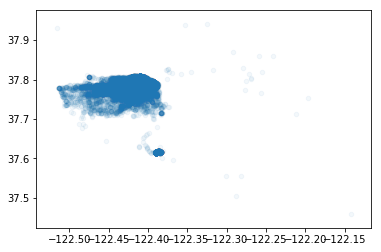

In [53]:
plt.scatter(trips['start_lng'], trips['start_lat'],s=20,alpha=.05)

**What do you think the little dot cluster is below?**

In [54]:

start_lat = trips['start_lat'][0]
start_lon = trips['start_lng'][0]
map = folium.Map(location=[start_lat, start_lon], zoom_start=11)


end_lat = trips['end_lat'][0]
end_long = trips['end_lng'][0]

circular_marker = folium.CircleMarker(location=[start_lat, start_lon],
                            radius = 1,
                            popup="My marker",
                            fill_color='blue',
                            color='grey',
                            fill_opacity=0.7)
marker_end = folium.CircleMarker(location=[end_lat, end_long],
                            radius = 1,
                            popup="My marker",
                            fill_color='dblue',
                            color='grey',
                            fill_opacity=0.7)

map.add_child(circular_marker)
map.add_child(marker_end)

**Hypothesis, maybe those are going to something of interest. what about SFO**

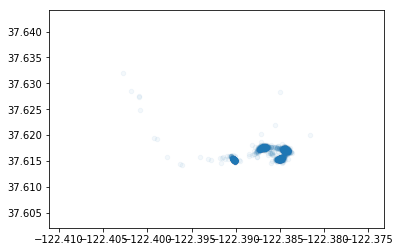

In [55]:
# plotting where the start 
plt.scatter(trips[trips['start_taz'] == 239]['start_lng'],trips[trips['start_taz'] == 239]['start_lat'], s=20, alpha=.05)

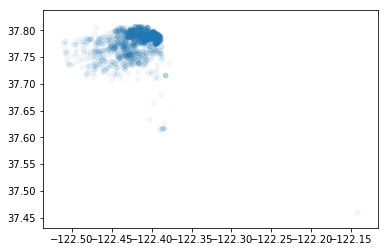

In [56]:
# plotting where they end
plt.scatter(trips[trips['end_taz'] == 239]['start_lng'],trips[trips['end_taz'] == 239]['start_lat'], s=20, alpha=.05)

**Looks like we have a cluster of trips that go to SFO, the distance is greater and it is plausibly they get taxed or it cost more to go there**

**Discuss**
how should we encode the importance of our SFO observation into our data?

In [57]:
trips['SFO'] = ((trips['start_taz'] == 239) | (trips['end_taz'] == 239)).astype(int)
trips.head()

,start_time,end_time,fare,number_pax,start_lng,start_lat,end_lng,end_lat,start_taz,end_taz,hour_start,weekday,SFO
0,9/1/12 0:11,9/1/12 0:20,13.20,1.0,-122.413540,37.802683,-122.421277,37.785395,38.0,30.0,0,5,0
1,9/1/12 0:23,9/1/12 0:31,10.65,1.0,-122.419700,37.786090,-122.435217,37.762177,30.0,94.0,0,5,0
2,9/1/12 0:45,9/1/12 0:49,9.00,1.0,-122.415120,37.774672,-122.407657,37.782615,10.0,11.0,0,5,0
3,9/1/12 0:41,9/1/12 0:54,13.95,2.0,-122.419392,37.806622,-122.415393,37.778115,40.0,10.0,0,5,0
4,9/1/12 1:09,9/1/12 1:13,7.35,1.0,-122.429722,37.797790,-122.418060,37.789032,45.0,32.0,1,5,0


## Outliers


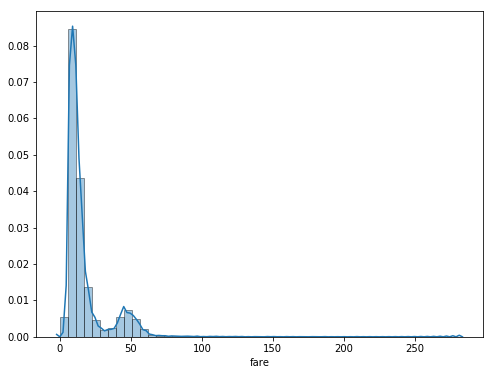

In [58]:
plt.figure(figsize=(8,6))
sns.distplot(trips['fare'])
# seems like most of the fares cluster around 0 to 30. and  a handful of quite high ones

In [59]:
trips.sort_values(by='fare',ascending=False).head()

,start_time,end_time,fare,number_pax,start_lng,start_lat,end_lng,end_lat,start_taz,end_taz,hour_start,weekday,SFO
9602,9/3/12 20:55,9/3/12 22:02,281.25,1.0,-122.387233,37.617143,-121.934592,38.272643,239.0,1252.0,20,0,1
23259,9/7/12 22:34,9/8/12 0:05,255.75,1.0,-122.384547,37.617148,-121.353468,37.982967,239.0,0.0,22,4,1
41438,9/11/12 1:24,9/11/12 2:16,219.35,1.0,-122.397640,37.793355,-121.889352,37.332805,1.0,558.0,1,1,0
13911,9/6/12 18:37,9/6/12 19:40,215.30,1.0,-122.390233,37.615377,-122.148178,38.052638,239.0,1211.0,18,3,1
9144,9/3/12 17:40,9/3/12 18:30,210.00,1.0,-122.390143,37.615127,-121.857482,37.301582,239.0,563.0,17,0,1


In [60]:
trips.sort_values(by='fare',ascending=True).head()

,start_time,end_time,fare,number_pax,start_lng,start_lat,end_lng,end_lat,start_taz,end_taz,hour_start,weekday,SFO
35114,9/10/12 22:27,9/10/12 22:44,0.0,1.0,-122.515832,37.929987,-122.441647,37.793855,1441.0,49.0,22,0,0
31922,9/11/12 21:31,9/11/12 21:42,0.0,1.0,-122.440477,37.770990,-122.400258,37.794973,88.0,22.0,21,1,0
16062,9/5/12 20:57,9/5/12 21:38,0.0,1.0,-122.394605,37.777168,-122.165267,37.444040,109.0,356.0,20,2,0
12112,9/4/12 7:08,9/4/12 7:29,0.0,1.0,-122.411138,37.748365,-122.439378,37.761283,119.0,94.0,7,1,0
16466,9/6/12 5:25,9/6/12 5:30,0.0,1.0,-122.393393,37.775633,-122.402975,37.786653,109.0,12.0,5,3,0


**looks like we have some really high fares, taz 0, and 0 fares**

will only address for taz for brevity<br>
0 taz refers to out of bay area 

In [61]:
trips[trips['start_taz'] == 0].shape[0]

1018

In [62]:
trips[trips['end_taz'] == 0].shape[0]

1214

In [63]:
trips.shape[0]

41897

In [64]:
trips['Taz 0'] = (trips['start_taz'] == 0) | (trips['end_taz'] == 0)
trips['Taz 0'] = trips['Taz 0'].astype(int)
trips.head()

,start_time,end_time,fare,number_pax,start_lng,start_lat,end_lng,end_lat,start_taz,end_taz,hour_start,weekday,SFO,Taz 0
0,9/1/12 0:11,9/1/12 0:20,13.20,1.0,-122.413540,37.802683,-122.421277,37.785395,38.0,30.0,0,5,0,0
1,9/1/12 0:23,9/1/12 0:31,10.65,1.0,-122.419700,37.786090,-122.435217,37.762177,30.0,94.0,0,5,0,0
2,9/1/12 0:45,9/1/12 0:49,9.00,1.0,-122.415120,37.774672,-122.407657,37.782615,10.0,11.0,0,5,0,0
3,9/1/12 0:41,9/1/12 0:54,13.95,2.0,-122.419392,37.806622,-122.415393,37.778115,40.0,10.0,0,5,0,0
4,9/1/12 1:09,9/1/12 1:13,7.35,1.0,-122.429722,37.797790,-122.418060,37.789032,45.0,32.0,1,5,0,0


**_Discuss_** 
What do you think we should do with fares that are 0?

In [65]:
sum(trips['fare'] == 0)

125

**lets drop some unncessary information now**

In [66]:
trips = trips.drop(['start_time','end_time','start_lng','start_lat','end_lng','end_lat'], axis=1)
trips.head()

,fare,number_pax,start_taz,end_taz,hour_start,weekday,SFO,Taz 0
0,13.20,1.0,38.0,30.0,0,5,0,0
1,10.65,1.0,30.0,94.0,0,5,0,0
2,9.00,1.0,10.0,11.0,0,5,0,0
3,13.95,2.0,40.0,10.0,0,5,0,0
4,7.35,1.0,45.0,32.0,1,5,0,0


**_Given what we have, what else could we augment and add to our dataset_?**

Discuss


# Part 2: Starting the ML Process

We will now go through the process if creating a model

**We will**
1. Create a baseline model 
1. Try a regression tree tuning one parameter
1. Tune multiple parameters
1. Try some different types of feature engineering


**baseline model**
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [68]:
# classic test train split
from sklearn.model_selection import train_test_split

train = trips.loc[:, trips.columns != 'fare']
target = trips['fare']
# splitting into train and test 
X_train, X_test, Y_train, Y_test = train_test_split(train, target, test_size=.1, random_state=42)

# splitting train into train and val
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=.223, random_state=42)

print('Precentage of data')
print()
print('Train','             Val','                Test')
print(X_train.shape[0] / trips.shape[0],X_val.shape[0] / trips.shape[0],X_test.shape[0] / trips.shape[0]  )

Precentage of data

Train              Val                 Test
0.6992863450843736 0.20070649449841277 0.10000716041721364


In [69]:
from sklearn.linear_model import LinearRegression

# Creating Loss Function 
rmse = lambda x, y: np.sqrt(np.mean((x-y)**2))

# Instaniating our model 
baseline = LinearRegression()

# training it 
baseline.fit(X_train, Y_train)

# evaluating it
train_error = rmse(baseline.predict(X_train), Y_train)

val_error = rmse(baseline.predict(X_val), Y_val)
print('Baseline Train Error')
print(train_error)
print()
print('Baseline Validation Error')
print(val_error)

Baseline Train Error
8.850905829208374

Baseline Validation Error
9.098413484279146


**Discuss**<br>
Why is training error less than validation error?

**Visualzing our model**

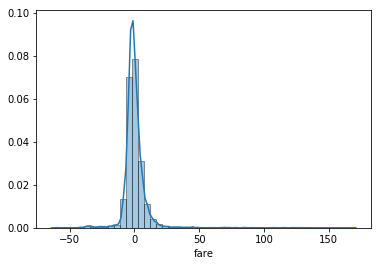

In [70]:
sns.distplot(Y_val - baseline.predict(X_val))

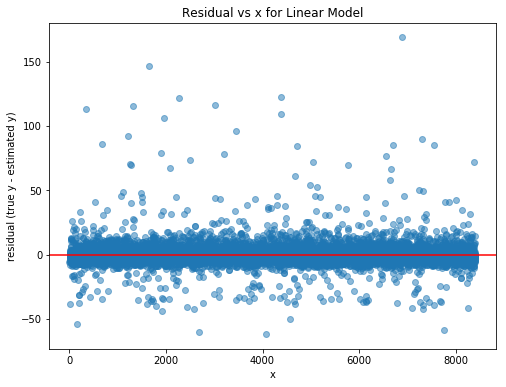

In [71]:
plt.figure(figsize=(8,6))      
plt.scatter(np.arange(len(X_val)), Y_val - baseline.predict(X_val),alpha=.5)
plt.xlabel('x')
plt.ylabel('residual (true y - estimated y)')
plt.title('Residual vs x for Linear Model')
plt.axhline(y = 0, color='r')

In [72]:
plt.figure(figsize=(8,6))
sns.distplot(bbaselineine.predict(X_val), hist=False, label='predicted')
sns.distplot(Y_val, hist=False, label='val')
plt.title('Distribution of test vs predicted')
plt.xlabel('Fare Price')

NameError: name 'bbaselineine' is not defined

<Figure size 576x432 with 0 Axes>

## Hyper parameter tuning

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [73]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
# n_estimators, criterion, max_depth, min_samples_split, min_samples_leaf, min_weight_fraction_leaf, max_features
# max_leaf_nodes, min_impurity_decrease, min_impurity_split

# set up sklearn's kfold object 
kf = KFold(n_splits=4)

# range of parameters to try
test_vals = [10,20,30,40,50]

val_errors = []

start = time.time()
for i in test_vals:
    # create new model for each testing value 
    model = RandomForestRegressor(n_estimators=i)
    
    # save errors here on each split
    validation_errors = []
    for train_idx, valid_idx in kf.split(X_train):
        # split the data
        split_X_train, split_X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx] 
        split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]

        # Fit the model on the training split
        model.fit(split_X_train, split_Y_train)
        
        # Compute the RMSE on the validation split
        pred = model.predict(split_X_valid)
        error = rmse(split_Y_valid, pred)


        validation_errors.append(error)
    # for each outer loop iteration, append the mean validation error as that error
    val_errors.append(np.mean(validation_errors))
print((time.time() - start)/60, ' minutes')

0.37426791588465375  minutes


In [74]:
for i in list(zip(test_vals, val_errors)):
    print(i)


(10, 5.928567501544466)
(20, 5.7660622809509166)
(30, 5.782413423756075)
(40, 5.724098899251317)
(50, 5.750589772055709)


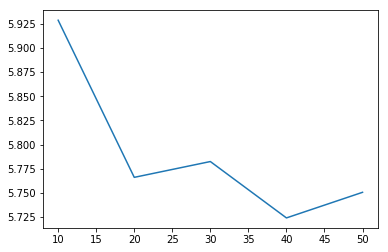

In [75]:
plt.plot(test_vals, val_errors)

In [76]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators':[10,50,100,150,300], 
          'max_features':['auto','sqrt','log2'],
          'max_depth': [5,15,30,45]}

grid = GridSearchCV(estimator=RandomForestRegressor(), 
                    param_grid=params, 
                    cv=2)

start = time.time()
grid.fit(X_train,Y_train)
print(f'{((time.time() - start) / 60)} minutes to fit')

3.6424125989278155 minutes to fit


In [83]:
for param, score in zip(grid.cv_results_['params'], grid.cv_results_['mean_test_score']):
    print(param, score)

{'max_depth': 5, 'max_features': 'auto', 'n_estimators': 10} 0.8217570304625328
{'max_depth': 5, 'max_features': 'auto', 'n_estimators': 50} 0.8268450215255768
{'max_depth': 5, 'max_features': 'auto', 'n_estimators': 100} 0.8288011099473606
{'max_depth': 5, 'max_features': 'auto', 'n_estimators': 150} 0.8281257895994355
{'max_depth': 5, 'max_features': 'auto', 'n_estimators': 300} 0.8292456256612573
{'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 10} 0.767550376807183
{'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 50} 0.7661803984772336
{'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 100} 0.7677501494357408
{'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 150} 0.7693246292500119
{'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 300} 0.771348206358768
{'max_depth': 5, 'max_features': 'log2', 'n_estimators': 10} 0.7861579710774922
{'max_depth': 5, 'max_features': 'log2', 'n_estimators': 50} 0.7671805659008569
{'max_depth': 5, 'max_features': 'lo

In [84]:
grid

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [10, 50, 100, 150, 300], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [5, 15, 30, 45]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [85]:
# grid 
train_error = rmse(grid.predict(X_train), Y_train)

val_error = rmse(grid.predict(X_val), Y_val)
print('Random Forest Train Error')
print(train_error)
print()
print('Random Forest Validation Error')
print(val_error)

Random Forest Train Error
3.235045897249246

Random Forest Validation Error
5.998015204174129


Text(0.5, 0, 'Fare Price')

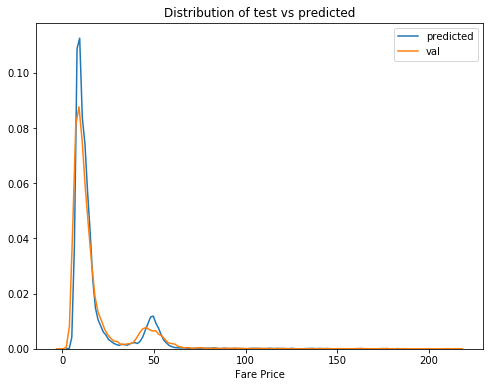

In [86]:
plt.figure(figsize=(8,6))
sns.distplot(grid.predict(X_val), hist=False, label='predicted')
sns.distplot(Y_val, hist=False, label='val')
plt.title('Distribution of test vs predicted')
plt.xlabel('Fare Price')

**Discuss** 

What do you observe about this model?

**It looks like our model isn't giving enough weight to most common ones, its also not capturing the trend around 50 dollars**

Hypothesis: The outliers in the model are pulling us away from the centers. Why might that be?

In [90]:
grid.best_params_

{'max_depth': 15, 'max_features': 'auto', 'n_estimators': 100}

In [ ]:
# Lets try the new model with mae as the error to weight outliers less
start = time.time()
mae_forrest = RandomForestRegressor(n_estimators=100, max_depth=10, criterion='mae')
print('fitting')
mae_forrest.fit(X_train, Y_train)
print('Done fitting')
train_error = rmse(mae_forrest.predict(X_train), Y_train)

val_error = rmse(mae_forrest.predict(X_val), Y_val)
print('Random Forest MAE Train Error')
print(train_error)
print()
print('Random Forest MAE Validation Error')
print(val_error)
print(f"Cell took {(time.time() - start)/60} minutes")

'''
Baseline Train Error
3.920464004333598

Baseline Validation Error
5.768882270003845
Cell took 11.767005225022634 minutes
'''

fitting


Text(0.5, 0, 'Fare Price')

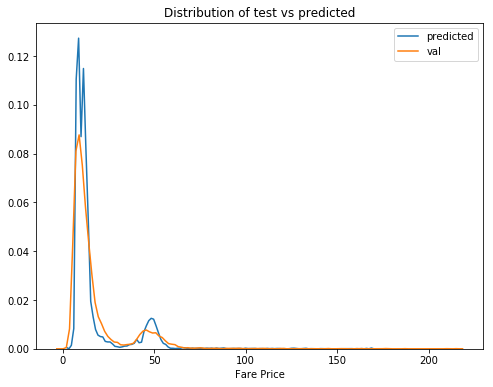

In [95]:
plt.figure(figsize=(8,6))
sns.distplot(mae_forrest.predict(X_val), hist=False, label='predicted')
sns.distplot(Y_val, hist=False, label='val')
plt.title('Distribution of test vs predicted')
plt.xlabel('Fare Price')

In [ ]:
## Regularization

In [ ]:
start = time.time()
# changing the depth in order to regularize
rmse_forest = RandomForestRegressor(n_estimators=100, max_depth=5)

rmse_forest.fit(X_train, Y_train)

train_error = rmse(rmse_forest.predict(X_train), Y_train)

val_error = rmse(rmse_forest.predict(X_val), Y_val)
print('Random Forest RMSE Train Error')
print(train_error)
print()
print('Random Forest RMSE Validation Error')
print(val_error)
print(f"Cell took {(time.time() - start)/60} minutes")

In [ ]:
plt.figure(figsize=(8,6))
sns.distplot(mae_forrest.predict(X_val), hist=False, label='predicted')
sns.distplot(Y_val, hist=False, label='val')
plt.title('Distribution of test vs predicted')
plt.xlabel('Fare Price')

**Discuss**

**What happened here?**<br>

**Extra Question**<br>
why did validation error increase instead of decrease?

In [ ]:
# example of a function to write once, then to run again when you need it.

def run_model(model, train, test, show_plot, show_res):
    ''' 
    Runs the sklearn's linear regression nd returns the rmse on training and test
    then plots the residuals. Also does Kfold cross validation 
    '''
    X_train, X_test, Y_train, Y_test = train_test_split(train, test, test_size=.1, random_state=np.random.seed(44))
    model.fit(X_train, Y_train)
    train_error = rmse(model.predict(X_train), Y_train)
    test_error = rmse(model.predict(X_test), Y_test)
    CV = compute_CV_error(model, train, test)
    print("Training RMSE:", train_error)
    print("CV RMSE:", CV)
    print("Test RMSE:", test_error)
    
   
    if show_res == True:
        y_pred = model.predict(X_train)
        plt.figure(figsize=(8,5))
        sns.distplot(Y_test, hist=False, label='test')
        sns.distplot(y_pred, hist=False, label='predicted')
        plt.title('Distribution of test vs predicted')
        plt.xlabel('Fare Price')
    if show_plot == True:
        plt.figure(figsize=(8,6))      
        plt.scatter(np.arange(len(X_test)), Y_test - model.predict(X_test), alpha=.5)
        plt.xlabel('x')
        plt.ylabel('residual (true y - estimated y)')
        plt.title('Residual vs x for Linear Model')
        plt.axhline(y = 0, color='r')

#         sns.kdeplot(np.arange(len(X_test)), Y_test - model.predict(X_test))
    return [train_error, CV, test_error]


def compute_CV_error(model, X_train, Y_train,k=4):
    '''
    Split the training data into subsets. Applies Kfold CV
    inputs:
        model: an sklearn model with fit and predict functions 
        X_train (data_frame): Training data
        Y_train (data_frame): Label 
    Return:
        the average validation MSE for the 4 splits.
    
    '''
    kf = KFold(n_splits=k)
    validation_errors = []
    
    for train_idx, valid_idx in kf.split(X_train):
        # split the data
        split_X_train, split_X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx] 
        split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]

        # Fit the model on the training split
        model.fit(split_X_train, split_Y_train)
        fit = model.predict(split_X_valid)
        # Compute the RMSE on the validation split
        error = rmse(split_Y_valid, fit)

        validation_errors.append(error)
        
    return np.mean(validation_errors)

    

**Discuss**

If you were delegating tasks to your team, what would you tell them to try  to improve our model? 

## Final observations 

**Now we have many hypotheses of how to improve our model**

1. We have a lot of deeper features to find. We now what what we want to do. 
1. We also know that our model isn't capturing something of importance near the middle. Could either be model tuning or features fed in. 
1. We know that outliers are doing something odd to our model. 

Given that this is a buisnesss problem, one model won't fix this. This could be done in colloboration with some heuristics and human intervention.

Should we have a whole seperate model to handle the outliers? Or should we let humans handle it. 

Better to create a model that says, given these parameters and setup, we do quite well. For these other cases, lets tackle it a different way

**Created by Alan Cha**<br>
**for Data Science Society Spring 2019 ML Workshop**<br>
**Creative Commons License**